# CPSC 330 Lecture 4

#### Lecture plan

- 👋
- **Turn on recording**
- Announcements
- Cross-validation True/False poll (5 min)
- Logistic regression intro (5 min)
- `CountVectorizer` and feature preprocessing pitfalls (35 min)
- Break (5 min)
- Logistic regression: `predict_proba` (10 min)
- Logistic regression: coefficients and interpretation (10 min)
- Logistic regression with continuous features (10 min)
- True/False questions (time-permitting)

## Learning objectives

- Apply logistic regression to classification problems
- Correctly apply `CountVectorizer` to preprocess text data (avoiding common pitfalls)
- Use `predict_proba` and interpret its output with a healthy dose of skepticism
- Interpret the coefficients of a trained logistic regression model
- Identify the key hyperparameter of `LogisticRegression` (namely, `C`)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 16

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

from plot_classifier import plot_classifier

## Announcements

- Add/drop deadline has passed - welcome to the course!
- hw1 grades posted, hw2 deadline passed (expect for late joiners), hw3 will posted later today, hw2 solutions will be posted tomorrow.
- Changes to class format.
  - Watch parties cancelled due to very low attendance.
  - We have Yuxi with us in lecture today.
  - We'll try Zoom chat today and probably try Piazza Live Q&A on Thursday to see what works better.
  - There are designated Q&A periods sprinkled throughout this lecture, where I will stop and answer questions.
  - Yuxi will answer some questions in real-time as well.
- For those who were added to the course recently:
  - If you did not complete hw1, you can drop it as your lowest hw grade.
  - You can have until 11:59pm tonight to complete hw2. 
  - You can still submit the syllabus quiz.

## Cross-validation True/False poll (5 min)

https://piazza.com/class/kb2e6nwu3uj23?cid=178

## Logistic regression intro (5 min)

#### Motivating example 

- Sentiment analysis: predict the sentiment of text, such as a movie review.
- Targets: positive 👍 and negative 👎
- Features: words (e.g., *excellent*, *well* for 👍 and *boring* for 👎)

<blockquote> 
    <p>Review 1: This movie was <b>excellent</b>! The performances were oscar-worthy!  👍 </p> 
    <p>Review 2: What a <b>boring</b> movie! I almost fell asleep twice while watching it. 👎 </p> 
    <p>Review 3: I enjoyed the movie. <b>Excellent</b>! 👍 </p>             
</blockquote>  

#### Intuition behind a linear classifier

- Learn coefficients (weights) associated with different features

<img src='img/words_coeff.png' width="300" height="300" />

- Use these learned coefficients to make predictions. For example, consider the following review $x_i$. 
<blockquote> 
    <p>It got a bit <b>boring</b> at times but the direction was <b>excellent</b> and the acting was <b>flawless</b>. </p> 
</blockquote>

#### Linear classifier 

- $\textrm{score}(review) = $ coefficient(*boring*) + coefficient(*excellent*) + coefficient(*flawless*) = $-1.40 + 1.93 + 1.43 = 1.96$
- Since $score(review) = 1.96 > 0$, predict the review as positive 👍. 
- Components of a linear model
    - input features
    - coefficients (weights), one per feature
    - bias or intercept

#### Logistic regression

In particular, we will focus on 
- use `fit`, `predict`, `predict_proba`
- use `coef_` to interpret the model weights 


## Q&A

(Pause for Q&A)

## `CountVectorizer` and the Golden Rule (35 min)

#### Let's train it on a dataset

I have downloaded the [IMDB movie review dataset](https://www.kaggle.com/utathya/imdb-review-dataset) from Kaggle. You should be able to download it as well. I did not push it to the home repo because it is large and because I don't have permission to redistribute it.

In [2]:
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999) # Take a subsample of the dataset for speed
imdb_df

,type,review,label,file
12438,test,As Jennifer Denuccio used to say on Square Peg...,neg,9946_2.txt
5705,test,"With Knightly and O'Tool as the leads, this fi...",neg,3886_3.txt
11675,test,"Take a bad script, some lousy acting and throw...",neg,9259_1.txt
9824,test,Strange things happen to Americans Will (Greg ...,neg,7593_3.txt
22581,test,"Sometimes, you're up late at night flipping th...",pos,7824_7.txt
...,...,...,...,...
31555,train,With a cast of stalwart British character acto...,neg,4650_2.txt
36478,train,There's a lot of movies that have set release ...,neg,9081_1.txt
35878,train,Welcome to movie 17 on the chilling classics 5...,neg,8541_1.txt
16040,test,"This is a forgotten classic of a film, and Har...",pos,1937_10.txt


In [3]:
imdb_df.shape

(10000, 4)

- Above, we used some key words in a review to decide how to classify it. 
- But here, we just have raw text:

In [4]:
imdb_df.loc[1,"review"]

"This is an example of why the majority of action films are the same. Generic and boring, there's really nothing worth watching here. A complete waste of the then barely-tapped talents of Ice-T and Ice Cube, who've each proven many times over that they are capable of acting, and acting well. Don't bother with this one, go see New Jack City, Ricochet or watch New York Undercover for Ice-T, or Boyz n the Hood, Higher Learning or Friday for Ice Cube and see the real deal. Ice-T's horribly cliched dialogue alone makes this film grate at the teeth, and I'm still wondering what the heck Bill Paxton was doing in this film? And why the heck does he always play the exact same character? From Aliens onward, every film I've seen with Bill Paxton has him playing the exact same irritating character, and at least in Aliens his character died, which made it somewhat gratifying...<br /><br />Overall, this is second-rate action trash. There are countless better films to see, and if you really want to s

We need a way to transform this raw text into use usual tabular format, where each column is a feature... hmm... 🤔

<br><br><br><br>

How about this: each word is a feature (column), and we check whether the word is present or absent in the review 💡

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

Make a `CountVectorizer` object:

In [6]:
vec = CountVectorizer(binary=True)

Note `binary=True` means just check whether a word is present (1) or absent (0), instead of counting the number of occurrences of the word.

Call `fit`:

In [7]:
vec.fit(imdb_df["review"]) 

CountVectorizer(binary=True)

For feature preprocessing objects, called _transformers_, we use `transform` instead of `predict` (indeed, it's not a prediction):

In [8]:
X = vec.transform(imdb_df["review"])

In [9]:
X[1].toarray()

array([[0, 0, 0, ..., 0, 0, 0]])

Hmm, is it only zeros for this first review?

In [10]:
X.shape

(10000, 52863)

That's a lot of columns!

In [11]:
vec.get_feature_names()[:20]

['00',
 '000',
 '001',
 '007',
 '0093638',
 '00pm',
 '00s',
 '01',
 '02',
 '03',
 '04',
 '041',
 '05',
 '06',
 '0615',
 '06th',
 '07',
 '08',
 '089',
 '0and']

- Ok, this seems like a lot of useless "words".
- We can use some hyperparameters of the `CountVectorizer` to just take more common words.
- Note: later in the course we will explore more options here.
  - For now we'll just focus on subsetting the features.

In [12]:
vec = CountVectorizer(min_df=50, binary=True) # words that appear at least n times

vec.fit(imdb_df["review"]) 

X = vec.transform(imdb_df["review"])

In [13]:
X.shape

(10000, 3243)

We can also explicitly ask for the top $n$ words:

In [14]:
vec = CountVectorizer(max_features=1000, binary=True) # max n columns

vec.fit(imdb_df["review"]) 

X = vec.transform(imdb_df["review"])

Note there is shorthand for this in scikit-learn:

In [15]:
X = vec.fit_transform(imdb_df["review"])

In [17]:
X.shape

(10000, 1000)

In [18]:
data_df = pd.DataFrame(data=X.toarray(), columns=vec.get_feature_names())
data_df

,10,20,30,80,able,about,above,absolutely,across,act,...,wrong,year,years,yes,yet,york,you,young,your,yourself
0,0,0,0,0,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,1,1,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,1,0,0,0,0,...,0,1,1,0,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9996,0,0,0,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,1,0
9997,1,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
9998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [20]:
y = imdb_df['label']
y

12438    neg
5705     neg
11675    neg
9824     neg
22581    pos
        ... 
31555    neg
36478    neg
35878    neg
16040    pos
12996    pos
Name: label, Length: 10000, dtype: object

## Q&A

(Pause for Q&A)

<br><br><br><br>

Ok, now we split the data...

Note there are two different ways to call `train_test_split`:

```python
df_train, df_test = train_test_split(df_all)
```

or

```python
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all)
```

Both are fine.

Note the order of the outputs though, I find it un-intuitive!

In [21]:
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X, y, random_state = 123)

Ok, this seems reasonable. Are we all good?

<br><br><br><br><br><br>

### NO!!

- Remember, the test data should be **unseen** data.
- Here, the test data influenced how we preprocessed the training data:
  - We used it to determine which words were the top words.
  - In fact, some of our features might be words that don't even appear in the training set!!
  - Thus, **the test error is no longer an accurate measure of how our model generalizes to unsees data**.
- This is called The Golden Rule of ML: the test data should not influence the training process in any way.
- If we violate the Golden Rule, our test score will be overly optimistic!
  - That is, deployment accuracy will probably be worse.

## The "Golden Rule"

- Previously, we used cross-validation to inform our choice of the least overfit model.
- Is this okay? It can be, if we don't do this too many times.
- If we use it too many times, we suffer from "optimization bias".

- The "golden rule" is that we need to be extremely vigilant about what data is being used for what.
- A test set should only be used "once".  
- Even if only used once, it won't be a perfect representation of deployment error:
  1. Bad luck (which gets worse if it's a smaller set of data)
  2. The deployment data comes from a different distribution
  3. And if it's used more than once, then you have another problem, which is that it influenced training and is no longer "unseen data".

Avoid this 3rd issue! The other two are bad enough.

## Q&A

<br><br><br><br>

Back to our dataset. We need to start over...

In [22]:
# Just to be safe
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)

We'll split right away to avoid violating the Golden Rule:

In [23]:
# STEP 1
imdb_train, imdb_test = train_test_split(imdb_df, random_state=123)

In [24]:
X_train_imdb_raw = imdb_train['review']
y_train_imdb = imdb_train['label']

X_test_imdb_raw = imdb_test['review']
y_test_imdb = imdb_test['label']

In [25]:
vec = CountVectorizer(min_df=50)

In [26]:
X_train_imdb = vec.fit_transform(X_train_imdb_raw)

In [27]:
X_test_imdb = vec.fit_transform(X_test_imdb_raw)

Now surely we're all good, right?

<br><br><br><br><br><br>

### NOPE

In [28]:
dt = DecisionTreeClassifier()

In [29]:
dt.fit(X_train_imdb, y_train_imdb);

In [30]:
dt.predict(X_test_imdb)

ValueError: Number of features of the model must match the input. Model n_features is 2573 and input n_features is 1025 

In [31]:
X_train_imdb.shape

(7500, 2573)

In [32]:
X_test_imdb.shape

(2500, 1025)

- What happened here?
- We fit the transformer on the training data, and transformed.
- Then we fit the transformer on the test data, and transformed.
- Now our data set makes no sense - we have a different number of columns in our train/test set!
- So, for example, the decision tree will split on a word "amazing", which is feature 2000, but then when we predict, we don't even have that feature!
- This is not a Golden Rule issue, it's just a preprocessing failure.
  - But note how the Golden Rule issue is harder to catch, because there's no Python error message.
 
Another rule: we must follow exactly the same preprocessing steps for train/test (and we'll bring this back to cross-validation next class).

In fact, if we had used `max_features` instead of `min_df` we wouldn't have even gotten a Python error message! See below:

In [39]:
vec = CountVectorizer(max_features=1000)

In [40]:
X_train_imdb = vec.fit_transform(X_train_imdb_raw)

In [41]:
vec.get_feature_names()[:3]

['10', '20', '80']

In [42]:
X_test_imdb = vec.fit_transform(X_test_imdb_raw);

In [43]:
vec.get_feature_names()[:3]

['10', '20', '30']

In [44]:
dt = DecisionTreeClassifier()

In [45]:
dt.fit(X_train_imdb, y_train_imdb);

In [46]:
dt.predict(X_test_imdb)

array(['neg', 'pos', 'neg', ..., 'neg', 'neg', 'neg'], dtype=object)

- Note: no error message.
- The problem is that the coefficients correspond to the **order** of the features, so the results will be completely invalid.

#### Attempt 3 (I promise it will be OK this time)

In [47]:
# Just to be safe
imdb_df = pd.read_csv('data/imdb_master.csv', index_col=0, encoding="ISO-8859-1")
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]
imdb_df = imdb_df.sample(frac=0.2, random_state=999)

In [48]:
# STEP 1
imdb_train, imdb_test = train_test_split(imdb_df, random_state=123)

In [49]:
X_train_imdb_raw = imdb_train['review']
y_train_imdb = imdb_train['label']

X_test_imdb_raw = imdb_test['review']
y_test_imdb = imdb_test['label']

In [50]:
vec = CountVectorizer(min_df=50, binary=True)

In [51]:
X_train_imdb = vec.fit_transform(X_train_imdb_raw)

We do not want this next line!!!

In [ ]:
# vec.fit(X_test_imdb_raw);

We transform the test data with the transformer _fit on the training data_!!

In [52]:
X_test_imdb = vec.transform(X_test_imdb_raw);

Ok, let's give this a try:

In [53]:
dt = DecisionTreeClassifier()
dt.fit(X_train_imdb, y_train_imdb);

In [54]:
dt.score(X_train_imdb, y_train_imdb)

1.0

In [55]:
dt.score(X_test_imdb, y_test_imdb)

0.686

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Break (5 min)



## Logistic regression: `predict_proba` (10 min)

In [62]:
from sklearn.dummy import DummyClassifier
dc = DummyClassifier(strategy="prior")

In [63]:
dc.fit(X_train_imdb, y_train_imdb);

In [64]:
dc.score(X_train_imdb, y_train_imdb)

0.5024

In [56]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_imdb, y_train_imdb);

In [57]:
lr.score(X_train_imdb, y_train_imdb)

0.9833333333333333

In [58]:
lr.score(X_test_imdb, y_test_imdb)

0.8256

Cool, we got a better test error this way!

#### Predicting probabilities

- Logistic regression seems to do fairly well on this task.
- Furthermore, we have a new and useful method, `predict_proba`.
- `predict` returns the class with the highest probability.
- Can we find the reviews where our classifier is most confident or least confident?
- How about reviews where the classifier is not very confident? 

In [67]:
lr.classes_

array(['neg', 'pos'], dtype=object)

In [65]:
probs = lr.predict_proba(X_test_imdb)
probs

array([[2.77104085e-02, 9.72289591e-01],
       [2.45126495e-01, 7.54873505e-01],
       [2.97764289e-05, 9.99970224e-01],
       ...,
       [3.45866415e-02, 9.65413358e-01],
       [3.67688371e-02, 9.63231163e-01],
       [1.23330879e-02, 9.87666912e-01]])

In [66]:
probs.shape

(2500, 2)

- It gives two columns, the probability of class 0 and the probability of class 1. 
- We only really care about one of them, since they add to 1. Let's take the second column:

In [68]:
lr.predict_proba(X_test_imdb)[:,1]

array([0.97228959, 0.75487351, 0.99997022, ..., 0.96541336, 0.96323116,
       0.98766691])

What's the most positive and most negative review according to our classifier?  


In [69]:
np.max(lr.predict_proba(X_test_imdb)[:,1])

0.9999999999977582

Wow! Let's find that review:

In [70]:
most_positive_ind = np.argmax(lr.predict_proba(X_test_imdb)[:,1])
most_positive_ind

1594

In [71]:
print(X_test_imdb_raw.iloc[most_positive_ind])

"Pitch Black" was a complete shock to me when I first saw it back in 2000. In the previous years, I was repeatedly disappointed by all the lame sci-fi movies (Ex: STARSHIP TROOPERS) and thought that this movie wouldn't be any different. But to plainly put it: This movie freaked me out... in a good way. I wasn't aware that I was still afraid of the dark till I watched this movie; I must have buried my fear in the back of my subconscious when I was a kid and it rightfully deserves to stay there.<br /><br />The alien creatures sent shivers up my spine; the individual(s) who designed them have a twisted but brilliant and creative imagination to come up with something so impressive and grotesque. <br /><br />I loved how the writers gave each main character a history and showed their flaws and strengths without much confusion.<br /><br />Riddick's (Vin Diesel) gift for escaping out of any impossible situation and putting up a hell of a fight was jaw dropping. At first, you figure him out to 

Most negative review:

In [77]:
np.min(lr.predict_proba(X_test_imdb)[:,1])

2.679889028418538e-13

In [72]:
most_negative_ind = np.argmax(lr.predict_proba(X_test_imdb)[:,0])
most_negative_ind

382

In [73]:
print(X_test_imdb_raw.iloc[most_negative_ind])

I'm a big horror film buff, particularly of the 1980's subgenres. Name one Â? I've probably seen it. Last year, a new little horror movie that seemed to slip under mainstream radar called "Saw" was about to hit theaters. I was moderately excited. Having not heard anything about it, I thought it looked quite promising judging by the previews and posters (well, except the back and white ones with the severed hands and feet...those just looked terrible!) I saw the film on opening night. It was one of the worst experiences of my life. This movie was literally mentally and psychically painful to watch. Because it was scary?...NO! Because it was one of the most awful movies I had ever had the displeasure of seeing! First off, the construction of the screenplay and editing was utterly atrocious, even by horror movie standards. Starting off a sequence in an interrogation room with a victim (Shawnee Smith) who recently survived a serial killer's attack, then showing a flashback of what she surv

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Logistic regression: coefficients and interpretation (10 min)

- One of the primary advantage of linear classifiers is their ability to interpret models. 
- What features are most useful for prediction? What words are swaying it positive or negative?

#### Let's find the most informative words for positive and negative reviews 

- The information you need is exposed by the `coef_` attribute of [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) object. 
- The vocabulary (mapping from feature indices to actual words) can be obtained as follows: 

In [78]:
lr.coef_

array([[-0.69748587,  0.68674704,  0.02057012, ..., -0.7324146 ,
        -0.550139  , -0.35196627]])

In [80]:
# Get features (words in our case)
vocab = vec.get_feature_names()
vocab[:10]

['000', '10', '100', '11', '12', '13', '15', '1950', '1970', '20']

In [81]:
weights = lr.coef_.ravel()
weights[:10]

array([-0.69748587,  0.68674704,  0.02057012, -0.15322152,  0.59517478,
       -0.27450501, -0.93007   ,  0.09361947, -0.73974962,  0.06040557])

In [82]:
words_weights_df = pd.DataFrame(data=weights, index=vocab, columns=['Weight'])
words_weights_df

,Weight
000,-0.697486
10,0.686747
100,0.020570
11,-0.153222
12,0.595175
...,...
your,0.015690
yourself,0.175757
youth,-0.732415
zero,-0.550139


In [83]:
words_weights_df.sort_values(by="Weight", ascending=False)

,Weight
perfect,1.729790
spectacular,1.620309
amazing,1.600239
loved,1.579306
surprisingly,1.562321
...,...
poorly,-2.015212
mess,-2.067356
awful,-2.137512
laughable,-2.204186


- These coefficients make sense!
- Let's use this to explore one of the test cases:

In [84]:
ex = 5
lr.predict_proba(X_test_imdb)[ex,1]

0.9993078189259635

In [86]:
lr.predict(X_test_imdb)[ex]

'pos'

In [87]:
X_test_imdb_raw.iloc[ex]

'As a convert into the Church of Jesus Christ of Latter Day Saints, I try to absorb as much as I can of my new religion\'s history. I was invited to attend a showing of this film with my sons & the other young men & women as well as their families of our ward. <br /><br />On a beautiful spring evening, we drove to Kirtland, Ohio to the church\'s historical village located there. We were to have had reservations at the Vistor\'s Center to view this movie. Since my movie viewing was limited to only a few church documentaries, I was intrigued. The only "full length motion pictures" of the church\'s I had seen was "Legacy" and "My Best Two Years", both which I thought were very well written and preformed.<br /><br />At the beginning, the missionary interpretor passed out tissues stating that several people had been deeply moved to the point of tears by this movie. I thought "OK...but it takes a lot to move me to tears." Imagine my surprise when I found myself sobbing! It truly is a very mo

We can find which of the vocabulary words are present in this review:

In [88]:
words_in_ex = X_test_imdb[ex].toarray().ravel().astype(bool)
words_in_ex

array([False, False, False, ..., False, False, False])

How many of the words are in this review?

In [89]:
np.sum(words_in_ex)

94

In [90]:
np.array(vocab)[words_in_ex]

array(['and', 'as', 'at', 'beautiful', 'been', 'beginning', 'believe',
       'best', 'both', 'br', 'but', 'by', 'can', 'center', 'church',
       'day', 'deeply', 'evening', 'families', 'few', 'film', 'found',
       'full', 'had', 'have', 'historical', 'history', 'imagine', 'in',
       'into', 'is', 'it', 'latter', 'length', 'limited', 'lot', 'me',
       'men', 'message', 'motion', 'move', 'moved', 'movie', 'moving',
       'much', 'my', 'myself', 'new', 'of', 'ok', 'on', 'only', 'other',
       'our', 'out', 'passed', 'people', 'pictures', 'point', 'powerful',
       'see', 'seen', 'several', 'showing', 'since', 'smith', 'surprise',
       'takes', 'tears', 'that', 'the', 'their', 'there', 'this',
       'thought', 'to', 'truly', 'try', 'two', 'very', 'view', 'viewing',
       'village', 'was', 'we', 'well', 'were', 'when', 'which', 'with',
       'women', 'written', 'years', 'young'], dtype='<U14')

In [91]:
ex_df = pd.DataFrame(data=weights[words_in_ex], index=np.array(vocab)[words_in_ex], columns=['Weight'])
ex_df

,Weight
and,0.027488
as,0.087752
at,-0.053590
beautiful,0.850001
been,-0.358442
...,...
with,0.184486
women,-0.393783
written,0.135455
years,0.652555


In [92]:
ex_df.sum()

Weight    6.459708
dtype: float64

- The more positive this value is, the closer to 1 the predicted probability would be. 
- Also, the more negative this value is, the closer to 0 the predicted probability would be. 
  - If this value were exactly 0, the predicted probability would be exactly 0.5.

#### Why people use logistic regression?  

- Logistic regression is extremely popular!
- Fast training and testing.
  - Training on huge datasets.
- Interpretability
  - Weights are how much a given feature changes the prediction and in what direction.

## Q&A

(Pause for Q&A)

<br><br><br><br>

## Logistic regression with continuous features (5 min)

In [93]:
cilantro_df = pd.read_csv('data/330-students-cilantro.csv')
cilantro_df.columns = ["meat", "grade", "cilantro"]

In [94]:
cilantro_train, cilantro_test = train_test_split(cilantro_df, random_state=1)

In [98]:
cilantro_train.head()

,meat,grade,cilantro
98,100.0,90,No
123,100.0,90,Yes
119,85.0,85,Yes
53,100.0,80,Yes
33,100.0,80,Yes


In [95]:
cilantro_X_train = cilantro_train[["meat", "grade"]]
cilantro_y_train = cilantro_train["cilantro"]

In [96]:
lr = LogisticRegression()
lr.fit(cilantro_X_train, cilantro_y_train);

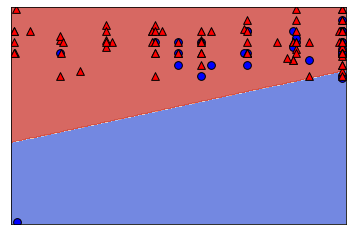

In [97]:
plot_classifier(cilantro_X_train, cilantro_y_train, lr);

In [99]:
lr.coef_

array([[-0.01768175,  0.05546546]])

- There are still some coefficients/weights being multiplied by the features.
- A linear classifier "slices the space in half" with a "hyperplane" (with 2 features, this is just a line).

Let's look at the predicted probabilties:

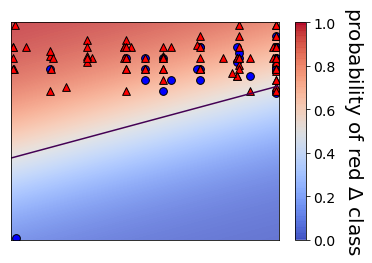

In [100]:
plot_classifier(cilantro_X_train, cilantro_y_train, lr, proba=True);

An important hyperparameter: `C` (default is `C=1.0`).

In [ ]:
lr = LogisticRegression(C=0.001)
lr.fit(cilantro_X_train, cilantro_y_train);
plot_classifier(cilantro_X_train, cilantro_y_train, lr, proba=True);

- Smaller `C` leads to less confident predictions (probabilties closer to 0.5).
- In general, we say smaller `C` leads to a less complex model (like a shallower decision tree).
  - Complex models are really a larger `C` in conjunction with lots of features.
  - Here we only have 2 features.

In [ ]:
lr = LogisticRegression(C=1000)
lr.fit(cilantro_X_train, cilantro_y_train);
plot_classifier(cilantro_X_train, cilantro_y_train, lr, proba=True);

Back to the IMDB dataset:

In [101]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_imdb, y_train_imdb)
lr.score(X_train_imdb, y_train_imdb)

0.9833333333333333

In [102]:
lr.score(X_test_imdb, y_test_imdb) 

0.8256

In [103]:
lr = LogisticRegression(max_iter=1000, C=10_000)
lr.fit(X_train_imdb, y_train_imdb)
lr.score(X_train_imdb, y_train_imdb)

1.0

In [104]:
lr.score(X_test_imdb, y_test_imdb) 

0.8044

Above: higher `C` leads to more overfitting.

In [105]:
lr = LogisticRegression(C=0.01)
lr.fit(X_train_imdb, y_train_imdb)
lr.score(X_train_imdb, y_train_imdb)

0.8949333333333334

In [106]:
lr.score(X_test_imdb, y_test_imdb) 

0.8416

Above: lower `C` leads to less overfitting.

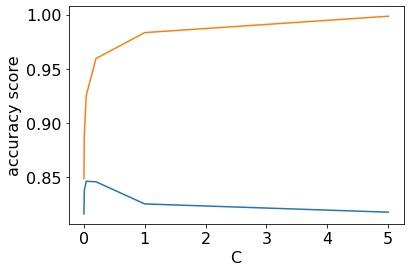

In [109]:
C_vals = 5.0**np.arange(-4,2)
scores = []
scores_train = []
for C in C_vals:
    lr = LogisticRegression(max_iter=1000, C=C)
    lr.fit(X_train_imdb, y_train_imdb)
    score_train = lr.score(X_train_imdb, y_train_imdb)
    score = lr.score(X_test_imdb, y_test_imdb)
    scores.append(score)
    scores_train.append(score_train)
plt.plot(C_vals, scores);
plt.plot(C_vals, scores_train);
plt.xlabel("C");
plt.ylabel("accuracy score");

## Next class & test set

- Note I previously said not to do hyperparameter tuning on the test set.
- We didn't use cross-validation today because we need one more element, Pipelines.
- Next class we'll talk about Pipelines and hyperparameter tuning.

## Q&A

(Pause for Q&A) 

<br><br><br><br>

## Summary

- IMDB movie review data: predict positive or negative review sentiment
- How to turn text into numeric features? Word counts (or presence/absence of a word).
  - This we create one column per word in our "vocabulary"
  - `max_features` hyperparameter controls how many words we include (takes the most frequent ones up to `max_features`)
- Make sure to split data _before_ preprocessing.
- Make sure not to call `fit` on validation/test data (this goes for both classifiers and transformers).
- `predict_proba`: useful confidence scores, but we won't interpret them as actual probabilities.
- Logistic regression coefficients: 
  - The sign matters: positive means increasing that feature gives a higher probability score for the "positive class" (arbitrarily defined for each problem)
  - The magnitude matters: larger coefficients means the feature contributes more toward the scores
- With `CountVectorizer` each feature is a word, thus each logistic regression coefficient corresponds to a word.
  - So, by looking at the coefficients we can get a sense of which words are the "most positive" and "most negative" (more on this later in the course!)
- Key hyperparameter of `LogisticRegression` is `C`; larger `C` leads to more complexity (higher training score, higher train-test gap)

## True/False questions

1. With `CountVectorizer`, we should `fit` on the training data and `transform` on both the train/test data.
2. `predict` returns the positive class if the predicted probability of the positive class is greater than 0.5.
3. Logistic regression overfits less than decision trees.
4. With logistic regression, we learn one weight per training example.